# Tutorial to use the harmonic Metropolis-Hastings sampling

In [1]:
import os, sys, time
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import scipy as sp
import jax
import jax.numpy as jnp
import fgbuster

import micmac

First, identify the directories for the param files

In [2]:
dir_params = "example_params/"

param_toml = dir_params + "corr_fullsky_LB_Harmonic.toml"
param_spv_yaml = dir_params + "params_spv_LB_nside0.yaml"

Then, create the harmonic sampler from the param files

In [3]:

Harm_obj = micmac.create_Harmonic_MICMAC_sampler_from_toml_file(param_toml, param_spv_yaml)

<_io.TextIOWrapper name='example_params/params_spv_LB_nside0.yaml' mode='r' encoding='UTF-8'>
count_b: 26
n_betas:  26

>>> Tree of spv config as passed by the User:
root
  nside_spv
    default: [0]
    f1
      default: None
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
      b5
        default: None
      b6
        default: None
      b7
        default: None
      b8
        default: None
      b9
        default: None
      b10
        default: None
      b11
        default: None
      b12
        default: None
    f2
      default: [0]
      b0
        default: None
      b1
        default: None
      b2
        default: None
      b3
        default: None
      b4
        default: None
      b5
        default: None
      b6
        default: None
      b7
        default: None
      b8
        default: None
      b9
        default: None
      b10
        default: None

Note that the object Harm_obj can also be created from MICMAC_Sampler.

# Generate input maps

Defining the parameters of the problem using **fgbuster**

In [4]:
input_seed = 43

In [5]:
nside = Harm_obj.nside

fgs_model = 'd0s0' # Defining the foreground model

# Define the instrument
instrument = fgbuster.get_instrument(Harm_obj.instrument_name)


In [6]:
# Get input foreground maps
freq_maps_fgs = fgbuster.get_observation(instrument, 
                                         fgs_model, 
                                         nside=Harm_obj.nside, 
                                         noise=True
                                         )[:, 1:, :]   # keep only Q and U


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Now retrieving the CMB maps and spectra using the r value given in the params files

In [7]:
input_freq_maps, input_cmb_maps, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = Harm_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


- input_freq_maps contains CMB+foregrounds+noise
- input_cmb_maps only contains CMB (over all frequencies)
- theoretical_red_cov_r0_total is the scalar mode spectrum given in format [lmax+1-lmin, nstokes, nstokes]
- theoretical_red_cov_r1_tensor is the tensor mode spectrum given in format [lmax+1-lmin, nstokes, nstokes]

To recover the format [number_correlations,lmax+1-lmin] from the format [lmax+1-lmin, nstokes, nstokes], we can call:

In [8]:
theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)

## Minimally informed approach

In order to do the minimally informed approach described in Leloup et al. 2023, we must define a correction term denoted C_approx.

In the approach, this can correspond to the scalar mode power spectrum, so we can define it as:

In [9]:
c_ell_approx = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)

From here, we have almost all the tools to compute the log-proba associated with the problem, we now need to set up the sampling itself.

# First guesses and covariance for the Metropolis-Hastings sampling

We can obtain the B_f covariance and r step-size through Fisher matrices computed prior

In [10]:
ls examples_Fisher_matrices/

Fisher_matrix_LiteBIRD_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt
Fisher_matrix_SO_SAT_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt


In [11]:
dir_Fisher = 'examples_Fisher_matrices/'

Fisher_matrix = np.loadtxt(dir_Fisher + 'Fisher_matrix_LiteBIRD_EB_model_d0s0_noise_True_seed_42_lmin2_lmax128.txt')

covariance_B_f = np.linalg.inv(Fisher_matrix)[:-1, :-1]
step_size_r = np.sqrt(np.linalg.inv(Fisher_matrix)[-1, -1])

We can compute the exact solutions for $B_f$ (with *d0s0*) from a given parametrisation with $\beta_d$, $T_d$, $\beta_s$

In [12]:
exact_solution_beta_mbb = 1.54
exact_solution_temp_mbb = 20.
exact_solution_beta_pl = -3.

In [13]:
init_mixing_matrix_obj = micmac.InitMixingMatrix(freqs=Harm_obj.frequency_array, 
                                                 ncomp=Harm_obj.n_components, 
                                                 pos_special_freqs=Harm_obj.pos_special_freqs, 
                                                 spv_nodes_b=Harm_obj.spv_nodes_b,
                                                 beta_mbb=exact_solution_beta_mbb,
                                                 temp_mbb=exact_solution_temp_mbb,
                                                 beta_pl=exact_solution_beta_pl)

theoretical_params = init_mixing_matrix_obj.init_params()


And then the first guess:

In [14]:
step_size_B_f = np.diag(sp.linalg.sqrtm(covariance_B_f))

gap_to_true_value = 10

init_params_mixing_matrix = theoretical_params + step_size_B_f * gap_to_true_value * np.random.randn(theoretical_params.size)

As for r, it can be anything sensible (between 0 and the current constraint)

In [15]:
initial_guess_r = 1e-8

We are now fully ready to perform the Harmonic Metropolis-Hastings sampling !

# Metropolis-Hastings sampling

As we have loaded from a file the covariance matrix, we can change it by setting the corresponding attribute to Harm_obj

In [16]:
Harm_obj.covariance_B_f = covariance_B_f
Harm_obj.step_size_r = step_size_r

Or we can set it up as the variable covariance_B_f_r to pass to perform_harmonic_MH

In [17]:
covariance_B_f_r = np.zeros((covariance_B_f.shape[0] + 1, covariance_B_f.shape[1] + 1))
covariance_B_f_r[:-1, :-1] = covariance_B_f
covariance_B_f_r[-1, -1] = step_size_r**2

We can change here the number of iterations of the Metropolis-Hastings, otherwise the one by default in the parameter file will be chosen

In [18]:
Harm_obj.number_iterations_sampling = 500

Then we can run the sampling itself

In [19]:
Harm_obj.perform_harmonic_MH(input_freq_maps, 
                             c_ell_approx, 
                             init_params_mixing_matrix, 
                             initial_guess_r=initial_guess_r,
                             theoretical_r0_total=theoretical_r0_total, 
                             theoretical_r1_tensor=theoretical_r1_tensor,
                             covariance_B_f_r=covariance_B_f_r,
                             print_bool=False)

Disabling chex !!!
Starting 500 iterations for harmonic run


sample: 100%|██████████| 500/500 [01:45<00:00,  4.76it/s]


End of MH iterations for harmonic run in 1.7543556849161783 minutes !


We can then retrieve the chains, which will be in the format [number_iterations+1, size_sample]

In [20]:
all_params_mixing_matrix_samples = Harm_obj.all_params_mixing_matrix_samples
all_r_samples = Harm_obj.all_samples_r

And finally plot them:

In [21]:
expected_burn_in = 50

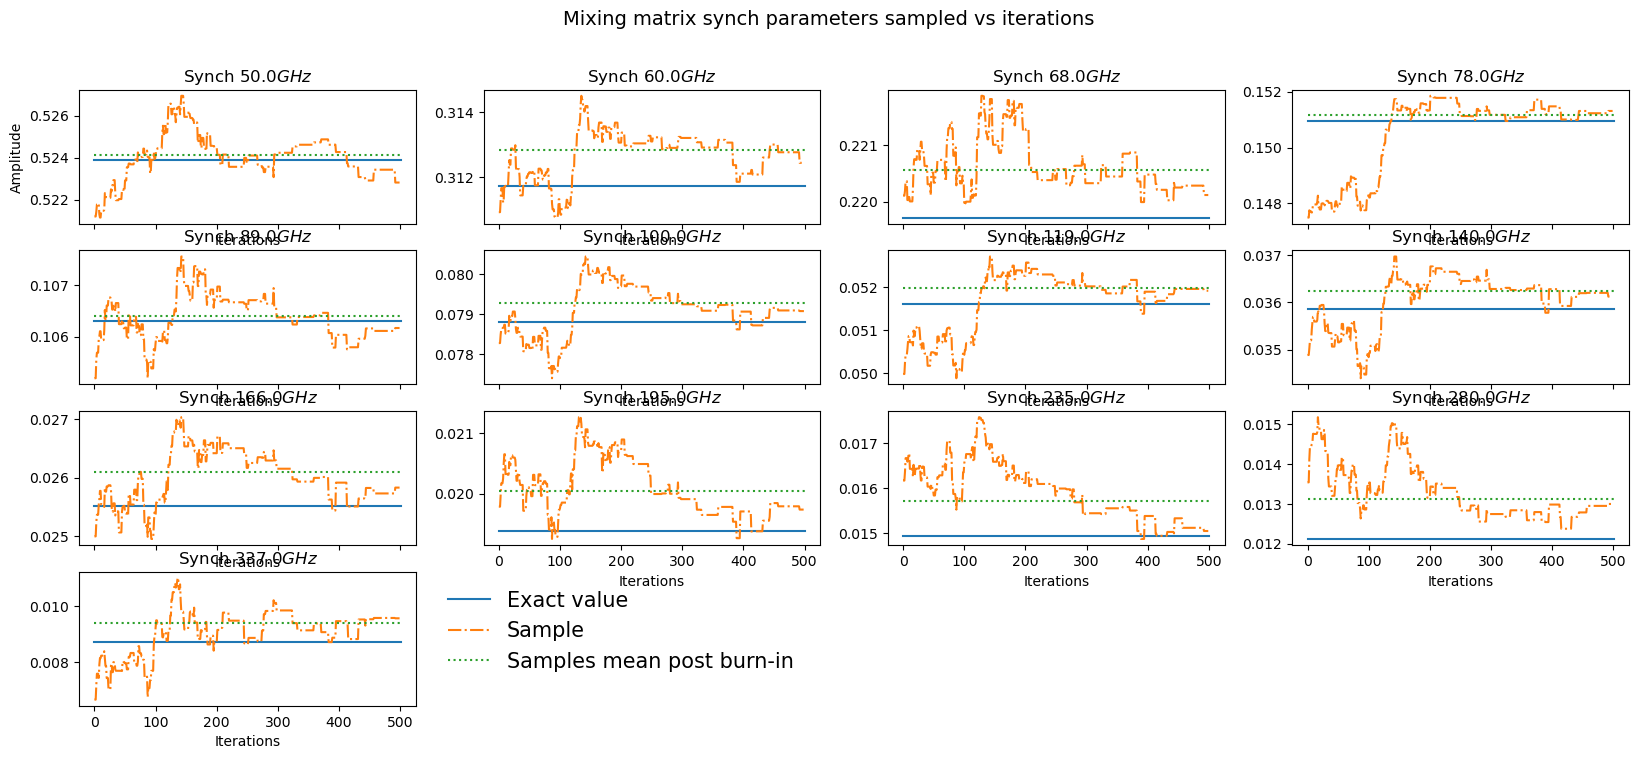

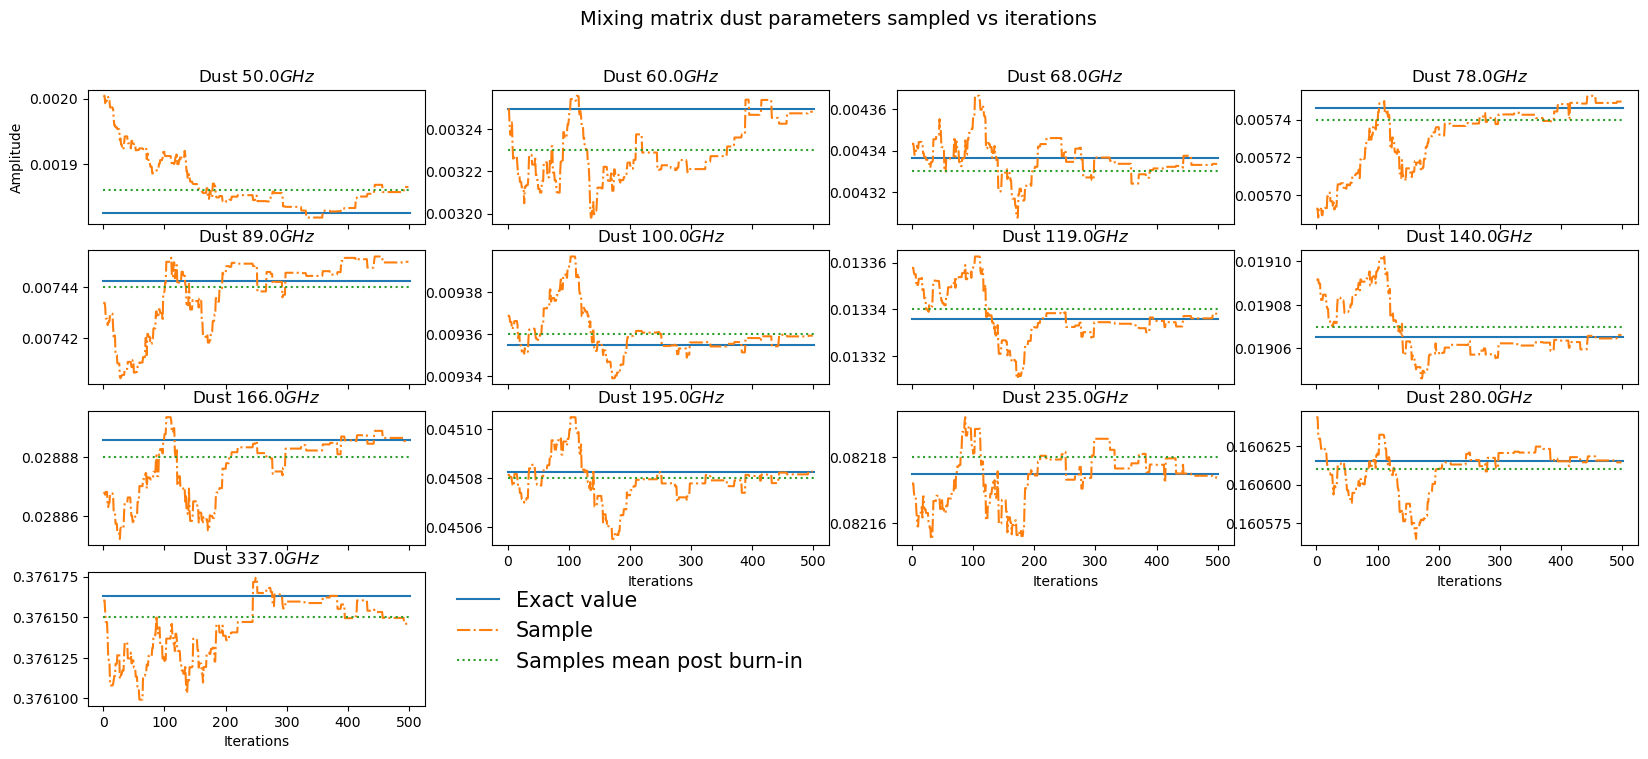

In [22]:
list_correl = ['EE', 'BB', 'EB']

red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)
ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + Harm_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
dim_Bf = len(frequency_Bf)
dim_synch = Harm_obj.indexes_b[0,1]
len_pos_special_freqs = len(Harm_obj.pos_special_freqs)


all_B_f_sample_synch = all_params_mixing_matrix_samples[:,:dim_synch]
all_B_f_sample_dust = all_params_mixing_matrix_samples[:,dim_synch:]

frequency_array = np.array(instrument['frequency'])

n_columns = 4
number_rows = (Harm_obj.n_frequencies-len_pos_special_freqs)//n_columns + 1

fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
useless_plots = number_rows*n_columns - (Harm_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

fig.suptitle(f"Mixing matrix synch parameters sampled vs iterations", fontsize=14)

for i in range(Harm_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//n_columns
    num_col = i%n_columns
    ax[num_row, num_col].set_title((f'Synch ${frequency_Bf[i]} GHz$'))
    
    ax[num_row, num_col].plot([0,Harm_obj.number_iterations_sampling+1], [theoretical_params[i],theoretical_params[i]], label='Exact value')
    ax[num_row, num_col].plot(np.arange(Harm_obj.number_iterations_sampling), all_B_f_sample_synch[:,i], '-.', label='Sample')

    cond = np.where(np.arange(Harm_obj.number_iterations_sampling+1) > expected_burn_in)[0]
    mean_B_f = np.round(all_B_f_sample_synch[cond,i][cond].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_synch[cond,i][cond].std(), decimals=5)

    mean_value = all_B_f_sample_synch[:,i].mean()
    ax[num_row, num_col].plot([0,Harm_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean post burn-in')

    ax[num_row, num_col].set_xlabel('Iterations')
    if i == 0:
        ax[num_row, num_col].set_ylabel('Amplitude')
    if i >= Harm_obj.n_frequencies-len_pos_special_freqs-n_columns:
        ax[num_row, num_col].set_xlabel('Iterations')
    else:
        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)

fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
useless_plots = number_rows*n_columns - (Harm_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

fig.suptitle(f"Mixing matrix dust parameters sampled vs iterations", fontsize=14)    
for i in range(Harm_obj.n_frequencies-len_pos_special_freqs):
    num_row = i//n_columns
    num_col = i%n_columns
    ax[num_row, num_col].set_title((f'Dust ${frequency_Bf[i]} GHz$'))
    ax[num_row, num_col].plot([0,Harm_obj.number_iterations_sampling+1], [theoretical_params[i+dim_synch],theoretical_params[i+dim_synch]], label='Exact value')
    ax[num_row, num_col].plot(np.arange(Harm_obj.number_iterations_sampling), all_B_f_sample_dust[:,i], '-.', label='Sample')

    cond = np.where(np.arange(Harm_obj.number_iterations_sampling+1) > expected_burn_in)[0]
    mean_B_f = np.round(all_B_f_sample_dust[cond,i].mean(), decimals=5)
    std_B_f = np.round(all_B_f_sample_dust[cond,i].std(), decimals=5)

    mean_value = all_B_f_sample_dust[:,i].mean()
    ax[num_row, num_col].plot([0,Harm_obj.number_iterations_sampling+1], [mean_B_f,mean_B_f], ':', label='Samples mean post burn-in')
    if i == 0:
        ax[num_row, num_col].set_ylabel('Amplitude')
    if i >= Harm_obj.n_frequencies-len_pos_special_freqs-n_columns:
        ax[num_row, num_col].set_xlabel('Iterations')
    else:
        ax[num_row, num_col].tick_params(axis='x', labelbottom=False)
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
plt.show()

And the corresponding histograms

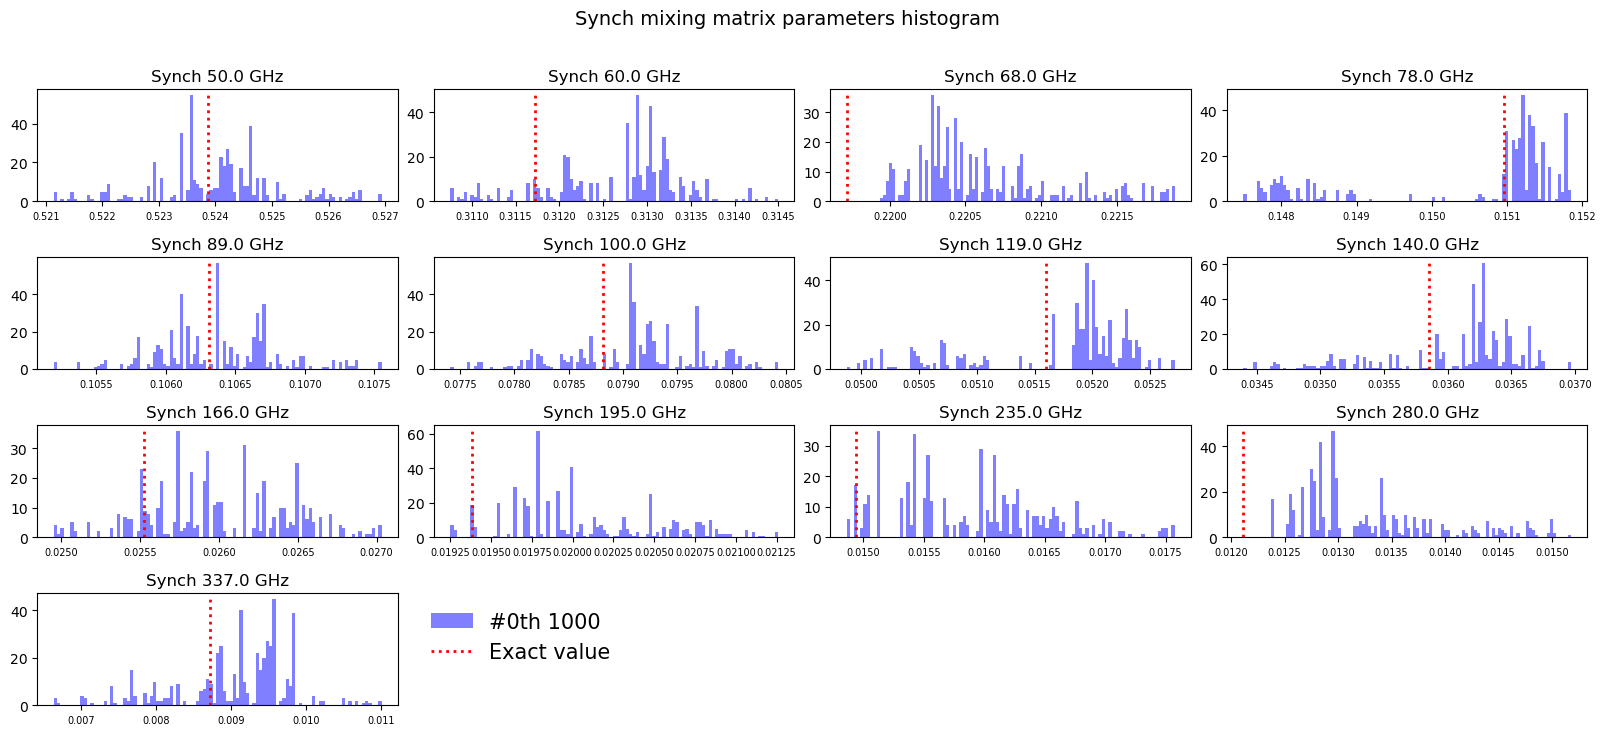

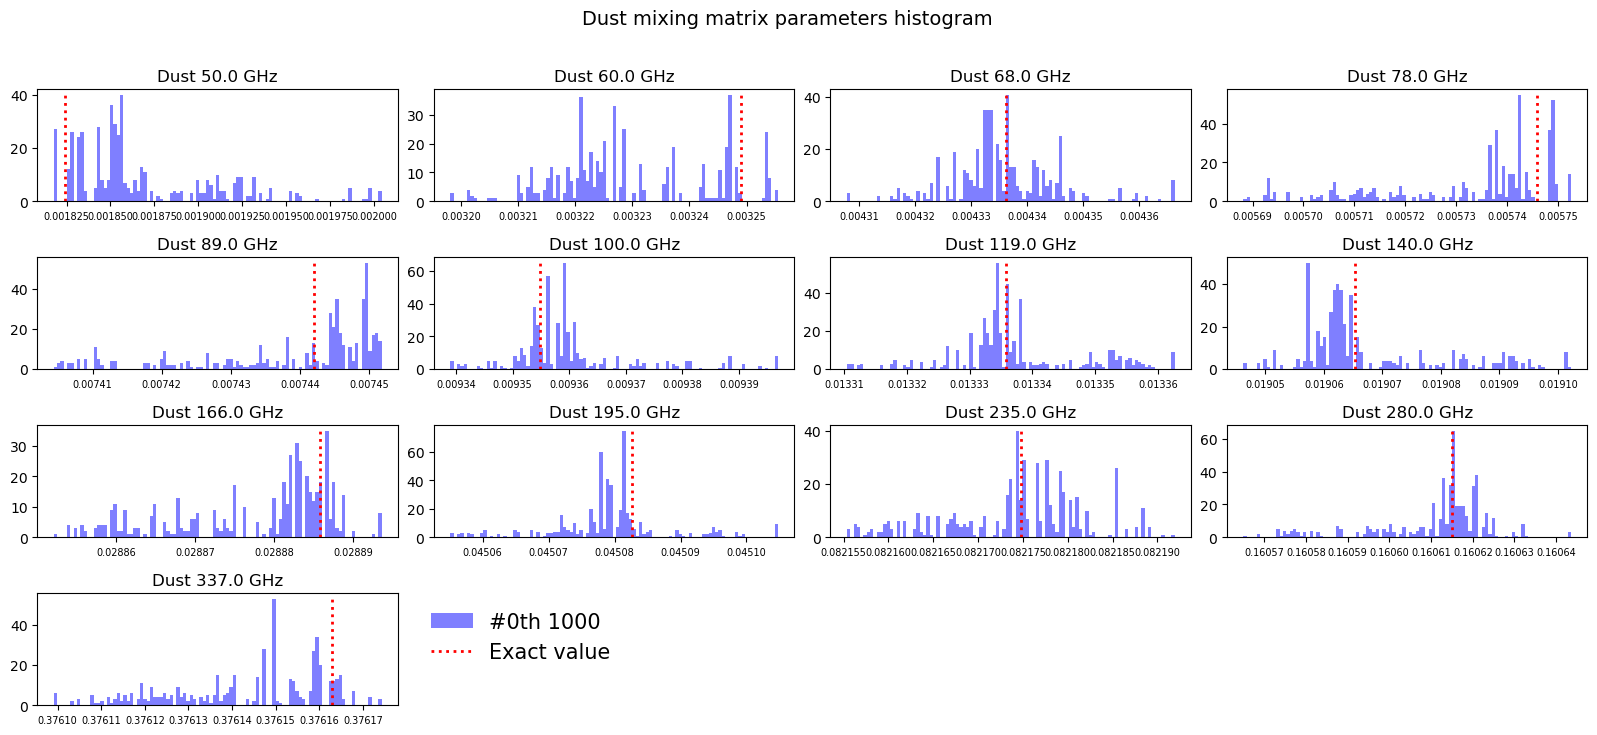

In [23]:
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(red_cov_approx_matrix.shape[0]) + Harm_obj.lmin

frequency_Bf = np.array(instrument['frequency'][1:-1])
frequency_array = np.array(instrument['frequency'])

num_iter_1000 = Harm_obj.number_iterations_sampling//1000
if Harm_obj.number_iterations_sampling%1000 != 0:
    num_iter_1000 += 1

color_list = ['blue', 'green', 'red', 'cyan', 'orange', 'yellow', 'purple', 'pink', 'brown', 'black', 
            'gray', 'olive', 'lime', 'teal', 'magenta', 'salmon', 'darkgreen', 'darkblue', 'darkred', 
            'darkcyan', 'darkorange', 'darkyellow', 'darkpurple', 'darkpink', 'darkbrown', 'darkgray', 'darkolive', 'darklime', 'darkteal', 'darkmagenta', 'darksalmon', 'lightgreen', 'lightblue', 'lightred', 'lightcyan', 'lightorange', 'lightyellow', 'lightpurple', 'lightpink', 'lightbrown', 'lightgray', 'lightolive', 'lightlime', 'lightteal', 'lightmagenta', 'lightsalmon', 'darkgreen', 'darkblue', 'darkred']


all_B_f_sample_synch = Harm_obj.all_params_mixing_matrix_samples[:,:dim_synch]
fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
plt.subplots_adjust(hspace=.5, wspace=.1)
fig.suptitle(f"Synch mixing matrix parameters histogram", fontsize=14)
useless_plots = number_rows*n_columns - (Harm_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

for i in range(len(frequency_Bf)):
    num_row = i//n_columns
    num_col = i%n_columns
    ax[num_row, num_col].set_title((f'Synch {frequency_Bf[i]} GHz'))
    ax[num_row, num_col].xaxis.set_tick_params(labelsize=7)
    if all_B_f_sample_synch[:,i].min() == all_B_f_sample_synch[:,i].max():
        min_value = all_B_f_sample_synch[:,i].min()*.9
        max_value = all_B_f_sample_synch[:,i].max()*1.1
    else:
        min_value = all_B_f_sample_synch[:,i].min()
        max_value = all_B_f_sample_synch[:,i].max()
    bins_array = np.linspace(min_value, max_value, 100)

    max_height = 0
    for j in range(num_iter_1000):
        heights, _, _ = ax[num_row, num_col].hist(all_B_f_sample_synch[j*1000:(j+1)*1000,i], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}th {1000}')
        max_height = max(max_height, heights.max())
    ax[num_row, num_col].plot([theoretical_params[i],theoretical_params[i]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


all_B_f_sample_dust = Harm_obj.all_params_mixing_matrix_samples[:,dim_synch:]
fig, ax = plt.subplots(number_rows, n_columns, figsize=(20,8))
plt.subplots_adjust(hspace=.5, wspace=.1)
fig.suptitle(f"Dust mixing matrix parameters histogram", fontsize=14)
useless_plots = number_rows*n_columns - (Harm_obj.n_frequencies-len_pos_special_freqs)
for idx_useless in range(0,useless_plots):
    num_row = (number_rows*n_columns)//n_columns
    num_col = (number_rows*n_columns)%n_columns
    fig.delaxes(ax[num_row-1, num_col-idx_useless-1])

for i in range(len(frequency_Bf)):
    num_row = i//n_columns
    num_col = i%n_columns
    ax[num_row, num_col].set_title((f'Dust {frequency_Bf[i]} GHz'))
    ax[num_row, num_col].xaxis.set_tick_params(labelsize=7)
    if all_B_f_sample_dust[:,i].min() == all_B_f_sample_dust[:,i].max():
        min_value = all_B_f_sample_dust[:,i].min()*.9
        max_value = all_B_f_sample_dust[:,i].max()*1.1
    else:
        min_value = all_B_f_sample_dust[:,i].min()
        max_value = all_B_f_sample_dust[:,i].max()
    bins_array = np.linspace(min_value, max_value, 100)

    max_height = 0
    for j in range(num_iter_1000):
        heights, _, _ = ax[num_row, num_col].hist(all_B_f_sample_dust[j*1000:(j+1)*1000,i], bins=bins_array, color=color_list[j], alpha=.5, label=f'#{j}th {1000}')
        max_height = max(max_height, heights.max())
    ax[num_row, num_col].plot([theoretical_params[i+dim_Bf],theoretical_params[i+dim_Bf]], [0,max_height], 'r:', linewidth=2.0, label='Exact value')
ax[num_row, num_col].legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)


plt.show()


The final values will be given by the average of the chains

In [24]:
final_B_f = all_params_mixing_matrix_samples.mean(axis=0)
final_r = all_r_samples.mean()

Then we can plot the corresponding residuals

In [25]:
expected_burn_in = 500
cond = np.where(np.arange(Harm_obj.number_iterations_sampling+1) > expected_burn_in)[0]

/Users/arizzieri/anaconda3/envs/micmac_env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  fig.canvas.print_figure(bytes_io, **kw)


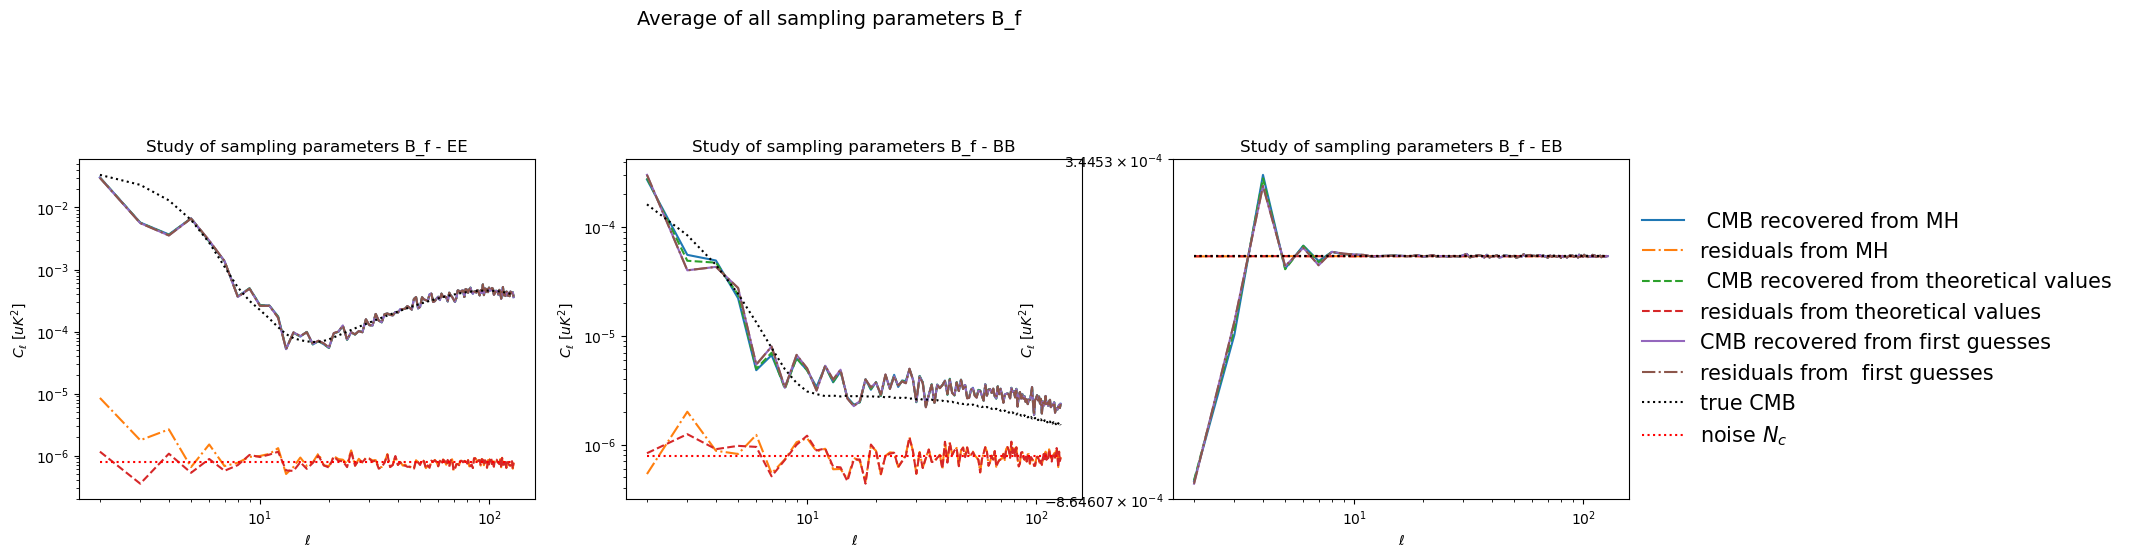

In [26]:
Harm_obj.freq_inverse_noise = micmac.get_noise_covar_extended(np.array(instrument['depth_p']), Harm_obj.nside)
indices_polarisation = np.array([1,2,4]) # Indices polarisation Anafast

# Residuals power spectrum
final_params = all_params_mixing_matrix_samples.mean(axis=0)
first_guess_params = all_params_mixing_matrix_samples[0]

# Retrieving the mixing matrix from the MH sampling
Harm_obj.update_params(final_params)
final_mixing_matrix = Harm_obj.get_B()

# Retrieving the mixing matrix from the first guesses
Harm_obj.update_params(first_guess_params)
first_guess_mixing_matrix = Harm_obj.get_B()


# Compute the theoretical CMB power spectrum
c_ell_true_CMB = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total + Harm_obj.r_true*theoretical_red_cov_r1_tensor)

# Compute the CMB component noise in harmonic domain
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), final_mixing_matrix.mean(axis=2), Harm_obj.lmax)[0,0,Harm_obj.lmin:]
red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))
cl_noise_harm = micmac.get_c_ells_from_red_covariance_matrix(red_cl_noise_harm)

# Retrieve the CMB from the maximum likelihood solution: (B^t N^-1 B)^-1 B^t N^-1 d
recovered_CMB_Wd = micmac.get_Wd(Harm_obj.freq_inverse_noise, final_mixing_matrix, input_freq_maps)[0, :, :] # For the whole MH
recovered_CMB_Wd_first_guess = micmac.get_Wd(Harm_obj.freq_inverse_noise, first_guess_mixing_matrix, input_freq_maps)[0, :, :] # For first guesses


# Retrieve the CMB from initial parameters given to the Initmixingmatrix object
Harm_obj.update_params(theoretical_params)
init_mixing_matrix_obj = Harm_obj.get_B()
recovered_CMB_Wd_th = micmac.get_Wd(Harm_obj.freq_inverse_noise, init_mixing_matrix_obj, input_freq_maps)[0, :, :]

# Compute residuals
residuals_Wd = recovered_CMB_Wd - input_cmb_maps[0]
residuals_Wd_first_guess = recovered_CMB_Wd_first_guess - input_cmb_maps[0]
residuals_Wd_th = recovered_CMB_Wd_th - input_cmb_maps[0]

# Retrieve spectra from all recovered CMB
recovered_CMB_Wd_extended = np.vstack([np.zeros_like(recovered_CMB_Wd[0]), recovered_CMB_Wd])
c_ells_recovered_CMB_Wd = hp.anafast(recovered_CMB_Wd_extended, lmax=Harm_obj.lmax, iter=Harm_obj.n_iter)[indices_polarisation,Harm_obj.lmin:]

recovered_CMB_Wd_first_guess_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_first_guess[0]), recovered_CMB_Wd_first_guess])
c_ells_recovered_CMB_Wd_first_guess = hp.anafast(recovered_CMB_Wd_first_guess_extended, lmax=Harm_obj.lmax, iter=Harm_obj.n_iter)[indices_polarisation,Harm_obj.lmin:]

recovered_CMB_Wd_th_extended = np.vstack([np.zeros_like(recovered_CMB_Wd_th[0]), recovered_CMB_Wd_th])
c_ells_recovered_CMB_Wd_th = hp.anafast(recovered_CMB_Wd_th_extended, lmax=Harm_obj.lmax, iter=Harm_obj.n_iter)[indices_polarisation,Harm_obj.lmin:]

# Retrieve spectra from all residuals
residuals_Wd_extended = np.vstack([np.zeros_like(residuals_Wd[0]), residuals_Wd])
c_ells_residuals_Wd = hp.anafast(residuals_Wd_extended, lmax=Harm_obj.lmax, iter=Harm_obj.n_iter)[indices_polarisation,Harm_obj.lmin:]

residuals_Wd_first_guess_extended = np.vstack([np.zeros_like(residuals_Wd_first_guess[0]), residuals_Wd_first_guess])
c_ells_residuals_Wd_first_guess = hp.anafast(recovered_CMB_Wd_first_guess_extended, lmax=Harm_obj.lmax, iter=Harm_obj.n_iter)[indices_polarisation,Harm_obj.lmin:]

residuals_Wd_th_extended = np.vstack([np.zeros_like(residuals_Wd_th[0]), residuals_Wd_th])
c_ells_residuals_Wd_th = hp.anafast(residuals_Wd_th_extended, lmax=Harm_obj.lmax, iter=Harm_obj.n_iter)[indices_polarisation,Harm_obj.lmin:]


plt.figure(figsize=(20,15))
list_correl = ['EE', 'BB', 'EB']
plt.suptitle(f"Average of all sampling parameters B_f", fontsize=14)
number_subplots_convention = 331
for i in range(len(list_correl)):
    plt.subplot(number_subplots_convention+i)
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+Harm_obj.lmin, c_ells_recovered_CMB_Wd[i,:], label=' CMB recovered from MH')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+Harm_obj.lmin, c_ells_residuals_Wd[i,:], '-.', label='residuals from MH')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+Harm_obj.lmin, c_ells_recovered_CMB_Wd_th[i,:], '--', label=' CMB recovered from theoretical values')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+Harm_obj.lmin, c_ells_residuals_Wd_th[i,:], '--', label='residuals from theoretical values')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+Harm_obj.lmin, c_ells_recovered_CMB_Wd_first_guess[i,:], label='CMB recovered from first guesses')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+Harm_obj.lmin, c_ells_residuals_Wd_first_guess[i,:], '-.', label='residuals from  first guesses')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+Harm_obj.lmin, c_ell_true_CMB[i,:], 'k:', label='true CMB')
    plt.plot(np.arange(c_ells_recovered_CMB_Wd.shape[-1])+Harm_obj.lmin, cl_noise_harm[i,:], 'r:', label='noise $N_c$')

    if i <= Harm_obj.nstokes-1:
        plt.loglog()
        plt.plot([Harm_obj.lmin,Harm_obj.lmax+1], [0,0], 'k:')
    else:
        plt.xscale('log')
        plt.yscale('symlog')
        plt.plot([Harm_obj.lmin,Harm_obj.lmax+1], [0,0], 'k:')
        plt.legend(bbox_to_anchor=(2.1, .5), loc='center right', prop={'size': 15}, frameon=False)
    plt.title('Study of sampling parameters B_f - {}'.format(list_correl[i]))
    plt.ylabel("$C_\ell$ [$uK^2$]")
    plt.xlabel(r"$\ell$")
    
plt.show()
